<a href="https://colab.research.google.com/github/da2985/e6885-adnet/blob/main/reinforce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Please use the following two lines to load from Google Drive

If your file is not there, upload it to https://drive.google.com/drive/folders/1tsPKyB2E1nW8Qw--kZ9GaeGW2u2-XoV6?usp=sharing

In [14]:
# This must be run within a Google Colab environment 
from google.colab import drive  
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
import sys
import os

sys.path.append('/content/gdrive/EE6885')

os.chdir("/content/gdrive/My Drive/EE6885")

### LOOK FOR AVAILABLE DATASETS IN THE FOLLOWING CELL. DO NOT DELETE

In [16]:
!ls adnet_datasets/OTB

 Basketball   Car1	 Deer	      Human3	 Mhyang         Soccer
 Biker	      Car2	 Dog	      Human4	 MotorRolling   Subway
 Bird1	      Car24	 Dog1	      Human5	 MountainBike   Surfer
 Bird2	      Car4	 Doll	      Human6	 Panda	        Suv
 BlurBody     CarDark	 DragonBaby   Human7	 RedTeam        Sylvester
 BlurCar1     CarScale	 Dudek	      Human8	 Rubik	        Tiger1
 BlurCar2     ClifBar	 FaceOcc1     Human9	 Shaking        Tiger2
 BlurCar3     Coke	 FaceOcc2     Ironman	 Singer1        Toy
 BlurCar4     Couple	 Fish	      Jogging	 Singer2        Trans
 BlurFace     Coupon	 FleetFace    Jump	 Skater         Trellis
 BlurOwl      Crossing	 Football1    Jumping	 Skater2        Twinnings
 Board	      Crowds	 Freeman1     KiteSurf	'Skater2 (1)'   Vase
 Bolt	      Dancer	 Girl	      Lemming	 Skating1       Walking
 Bolt2	      Dancer2	 Girl2	      Liquor	 Skating2       Walking2
 Box	      David2	 Gym	      Man	 Skating3       Woman
 Boy	      David3	 Human2       Matrix	 Skiing


In [8]:
pip install hdf5storage

     |████████████████████████████████| 53 kB 1.7 MB/s 


In [5]:
pip install tensorflow-addons

     |████████████████████████████████| 1.1 MB 7.7 MB/s 


In [17]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa

import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers

import cv2
import glob
import hdf5storage
import math
import random
import re

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import scipy.io as sio

import linecache

from typing import Dict, List, Tuple
from operator import add
import copy

In [18]:
 %load_ext autoreload 
 %autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# MODEL DEFINITIONS

In [19]:
class ADNET(tf.keras.Model):

    ACTION_DIM = 11
    K = 10

    def __init__(self):
        super(ADNET, self).__init__()

        self.action_history = tf.keras.layers.Input(shape = (1,1, ADNET.ACTION_DIM * ADNET.K))

        self.conv1 = tf.keras.layers.Conv2D(filters = 96, kernel_size = (7, 7), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_1')
        self.max1  = tf.keras.layers.MaxPooling2D(pool_size=(3,3), strides = (1, 1), padding = 'VALID')
        self.conv2 = tf.keras.layers.Conv2D(filters = 256, kernel_size = (5, 5), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_2')
        self.max2  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (2, 2), padding = 'VALID')
        self.conv3 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), strides = (2, 2), padding = 'VALID', activation = 'relu', name = 'conv_3')
        self.max3  = tf.keras.layers.MaxPool2D(pool_size=(3, 3), strides = (1, 1), padding = 'VALID')
        
        self.fc1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = 'VALID', activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (1,1), padding = 'VALID', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Conv2D(filters = 11, kernel_size = (1,1), padding = 'VALID', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Conv2D(filters = 2, kernel_size = (1,1), padding = 'VALID', name = 'fc4',activation="softmax")

        self.dropout1=tf.keras.layers.Dropout(0)
        self.dropout2=tf.keras.layers.Dropout(0)
        

    def build(self, action_history):
      super(ADNET, self).build((None, 112, 112, 3))
      self.action_history=action_history

    def setActionHistory(self, action_history):
      self.action_history=action_history.reshape((1, 1, 1, ADNET.ACTION_DIM * ADNET.K))

    def call(self, input_tensor, training=False):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)

        x = self.fc1(x)
        x=  self.dropout1(x)
        x = self.fc2(x)
        x=  self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]

    def callForAction(self, input_tensor, training=False):
      '''
      Wrapper action for model.call() to only output action probabilities.
      For RL purposes, this is the only relevant output (as of 12/2/2021).
      '''
      return self.call(input_tensor, training)[0]

    def compile(self, optimizer):
   		super().compile(optimizer, loss={
         'output_1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
         'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
         })
     
    def getEmbedding(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        return tf.reshape(x,(-1,))

    def getFC1(self,input_tensor):
        x = self.conv1(input_tensor)
        x = self.max1(x)
        x = self.conv2(x)
        x = self.max2(x)
        x = self.conv3(x)
        x = self.max3(x)
        x = self.fc1(x)
        return x
      
    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

def setWeights(model, weights, weights2):
  model.layers[0].set_weights([weights2["conv1f"],tf.reshape(weights2["conv1b"],(96,))])
  model.layers[2].set_weights([weights2["conv2f"],tf.reshape(weights2["conv2b"],(256,))])
  model.layers[4].set_weights([weights2["conv3f"],tf.reshape(weights2["conv3b"],(512,))])
  
  model.layers[6].set_weights([weights["fc4f"],tf.reshape(weights["fc4b"],(512,))])
  model.layers[7].set_weights([weights["fc5f"],tf.reshape(weights["fc5b"],(512,))])
  model.layers[8].set_weights([weights["fc6_1f"],tf.zeros(11)])
  model.layers[9].set_weights([weights["fc6_2f"],tf.zeros(2)])
  
  return model

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [20]:
class ADNET_v2(tf.keras.Model):
    def __init__(self):
        super(ADNET_v2, self).__init__()

        #self.action_history = tf.keras.layers.Input(shape = (1,1,110))
        self.action_history = tf.keras.layers.Input(shape = (110))

        self.resnet=tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(112,112,3),pooling="max")
        #self.resnet = tf.keras.applications.ResNet50V2(include_top=False,weights="imagenet",input_shape=(112,112,3),pooling=None)
        #self.conv1 = tf.keras.layers.Conv2D(filters = 128, kernel_size = (4,4), padding = 'VALID', name = 'fc4',activation="relu")
        
        self.fc1 = tf.keras.layers.Dense(512,kernel_initializer='glorot_uniform',activation = 'relu', name = 'fc1')
        self.fc2 = tf.keras.layers.Dense(512,kernel_initializer='glorot_uniform', activation = 'relu', name = 'fc2')
        self.fc3 = tf.keras.layers.Dense(11,kernel_initializer='glorot_uniform', name = 'fc3',activation="softmax")
        self.fc4 = tf.keras.layers.Dense(2,kernel_initializer='glorot_uniform',name = 'fc4',activation="softmax")

        self.dropout1=tf.keras.layers.Dropout(0)
        self.dropout2=tf.keras.layers.Dropout(0)
        

    def build(self, action_history):
      super(ADNET_v2, self).build((None, 112, 112, 3))
      self.action_history=action_history
      self.resnet.trainable = False

    def setActionHistory(self, action_history):
      self.action_history=action_history

    def call(self, input_tensor, training=False):
        x = self.resnet(input_tensor)
        #x = self.conv1(x)

        x = self.fc1(x)
        x=  self.dropout1(x)
        x = self.fc2(x)
        x=  self.dropout2(x)
        x = tf.keras.layers.Concatenate(axis=-1)([x, self.action_history])
        action = self.fc3(x)
        confidence = self.fc4(x)
        return [action, confidence]

    def callForAction(self, input_tensor, training=False):
      '''
      Wrapper action for model.call() to only output action probabilities.
      For RL purposes, this is the only relevant output (as of 12/2/2021).
      '''
      return self.call(input_tensor, training)[0]

    # def compile(self, optimizer):
   	# 	super().compile(optimizer, loss={
    #      'output_1':tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    #      'output_2': tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    #      })
     
    def debugModelSummary(self):
      '''
      call model.debugModelSummary().summary() to get around the inconvenience 
      from model.summary() returning 'multiple' for each layer's output shape
      '''
      dummyInput = tf.keras.layers.Input(shape = (112,112,3))
      return tf.keras.Model(inputs=[dummyInput], outputs = self.call(dummyInput))

# HELPER FUNCTIONS

[290 239  34  81]
[171 128  99 316]


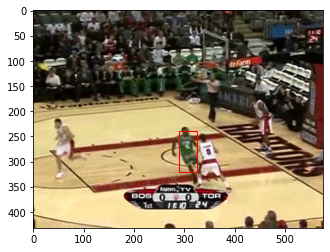

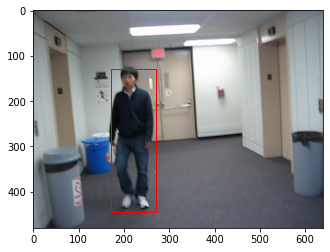

In [21]:
# DEBUGGING helper functions for accessing getting ground truth and image files

def human_readable_action(index: int) -> str:
  '''
  Map action numbers to human readable strings
  '''
  def _get_action(index:int) -> str:
    if index == 0:
      return "left"
    elif index == 1:
      return "2x left"
    elif index == 2:
      return "right"
    elif index == 3:
      return "2x right"
    elif index == 4:
      return "up"
    elif index == 5:
      return "2x up"
    elif index == 6:
      return "down"
    elif index == 7:
      return "2x down"
    elif index == 8:
      return "stop"
    elif index == 9:
      return "scale down"
    elif index == 10 :
      return "scale up"
  return _get_action(index).upper()


def get_ground_truths(ground_truth_file: str) -> np.array:
  '''
  Use me to convert a ground_truth_file to a numpy array
  '''
  with open(ground_truth_file) as f:
    ground_truths = f.readlines()
    to_nparray = lambda s: np.array(re.findall('\d+', s), dtype=int)
    truths = list(map(to_nparray, ground_truths))
    return np.asarray(truths)
  return None

def plotNpImageBBox(img: np.array, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x, y, w, h = bbox
  rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect)
  plt.imshow(img)
  return bbox

def plotNpImageBBoxes(img: np.array, src_bbox: np.array, target_bbox: np.array, 
                      pred_bbox: np.array) -> np.array:
  '''
  Plots the bounding boxes on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x1, y1, w1, h1 = src_bbox
  x2, y2, w2, h2 = target_bbox
  x3, y3, w3, h3 = pred_bbox
  rect1 = patches.Rectangle((x1, y1), w1, h1, linewidth=1, edgecolor='b', facecolor='none')
  rect2 = patches.Rectangle((x2, y2), w2, h2, linewidth=1, edgecolor='g', facecolor='none')
  rect3 = patches.Rectangle((x3, y3), w3, h3, linewidth=1, edgecolor='r', facecolor='none')
  ax.add_patch(rect1)
  ax.add_patch(rect2)
  ax.add_patch(rect3)
  plt.imshow(img)
  return pred_bbox  

def plotImageBBox(img: str, bbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image (from given filepath) and returns the 
  bounding box
  '''
  img = cv2.imread(img)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plotNpImageBBox(img, bbox)
  return bbox

def plotDatasetImageBBox(dataset: str, frame_no: int) -> Tuple[np.array, int]:
  '''
  Plot an image's bounding box. Returns the ground truth and frame number.
  WORKS FOR OTB100
  '''
  imgs = sorted(glob.glob("{0}/img/*".format(dataset)))
  gt = get_ground_truths("{0}/groundtruth_rect.txt".format(dataset))
  plotImageBBox(imgs[frame_no], gt[frame_no])
  return gt[frame_no], frame_no


print(plotDatasetImageBBox("adnet_datasets/OTB/Basketball", 50)[0])
print(plotDatasetImageBBox("adnet_datasets/OTB/BlurBody", 10)[0])

In [22]:
# MOVEMENT helper functions

ALPHA = 0.03 # See p. 4 of the paper
STOP_ACTION_INDEX = 8
MIN_WINDOW_SIZE = 10

def calculate_IOU(bbox1: np.array, bbox2: np.array):
    x1, y1, w1, h1 = bbox1
    x2, y2, w2, h2 = bbox2
           
    i_x1 = max(x1, x2)
    i_y1 = max(y1, y2)
    i_x2 = min(x1 + w1, x2 + w2)
    i_y2 = min(y1 + h1, y2 + h2)
    if i_x1 >= i_x2 or i_y1 >= i_y2:
      return 0.0

    intersection_area = (i_x2 - i_x1) * (i_y2 - i_y1)
    box1_area = w1 * h1
    box2_area = w2 * h2
    
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou


def move(image: np.array, bbox: np.array, action: str, 
         stride_magnitude: int=1) -> np.array:
  '''
  Returns the new bounding box after taking an action: 
  {"left", "right", "up", "down"}. Use stride to indicate the step size.
  '''
  if action not in set(["left", "right", "up", "down"]):
    raise RuntimeError("Invalid action taken :(") 
  
  x, y, w, h = bbox
  if action in set(["left", "right"]):
    step = max(1, int(ALPHA * w)) * stride_magnitude * (-1 if action=="left" else 1)
    if 0 <= x + step < image.shape[1] - w:
      x = x + step 
  else:
    step = max(1, int(ALPHA * h)) * stride_magnitude * (-1 if action=="up" else 1)
    if 0 <= y + step < image.shape[0] - h:
      y = int(y + step)

  return np.array([int(x), int(y), w, h])

def scale(image: np.array, bbox: np.array, scaleUp: bool):
  x, y, w, h = bbox
  deltaW, deltaH = max(2, ALPHA * w), max(2, ALPHA * h)
  if not scaleUp: 
    deltaW *= -1
    deltaH *= -1
  w = min(image.shape[1], max(MIN_WINDOW_SIZE, int(w + deltaW))) 
  h = min(image.shape[0], max(MIN_WINDOW_SIZE, int(h + deltaH)))
  x = int(x + -1 * deltaW / 2)
  y = int(y + -1 * deltaH / 2)
  return np.array([x, y, w, h])

def selectAction(img: np.array, bbox: np.array, index: int): 
  if index == 0 :
    bbox = move(img, bbox, "left")
  elif index == 1 :
    bbox = move(img, bbox, "left", stride_magnitude=2)
  elif index == 2 :
    bbox = move(img, bbox, "right")
  elif index == 3 :
    bbox = move(img, bbox, "right", stride_magnitude=2)  
  elif index == 4 :
    bbox = move(img, bbox, "up")  
  elif index == 5 :
    bbox = move(img, bbox, "up", stride_magnitude=2)
  elif index == 6 :
    bbox = move(img, bbox, "down")
  elif index == 7 :
    bbox = move(img, bbox, "down", stride_magnitude=2)
  elif index == 8:
    bbox = bbox
  elif index == 9 :
    bbox = scale(img, bbox, False)     # Scale Down
  elif index == 10 :
    bbox = scale(img, bbox, True)      # Scale Up

  x, y, w, h = bbox
  assert 0 <= x < image.shape[1] - w
  assert 0 <= y < image.shape[0] - h
  assert MIN_WINDOW_SIZE <= w <= image.shape[1]
  assert MIN_WINDOW_SIZE <= h <= image.shape[0]
  return index, bbox


def selectMaxAction(img: np.array, bbox: np.array, action_probs: np.array): 
  a = tf.math.argmax(action_probs)
  return selectAction(img, bbox, a)


def sampleAction(img: np.array, bbox: np.array, action_probs: np.array):  
  # Normalize probabilities and make sure there's mass added to all of them
  action_probs = np.array(action_probs) + 1e-5
  action_probs /= action_probs.sum()
  
  a = np.random.choice(np.arange(len(action_probs)), p=action_probs)
  return selectAction(img, bbox, a)


def isStop(action: int):
  return action == STOP_ACTION_INDEX


[138  41  32  89]
IOU: 0.0
Test bbox is: [159  50  21  82]


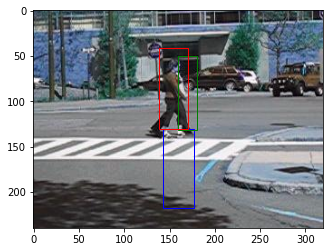

In [23]:
# Update this with the appropriate dataset
TEST_IMAGE_PATH = "adnet_datasets/OTB/Couple/img/0082.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Couple/groundtruth_rect.txt")[82]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)


# Update the following two vars
src_bbox = np.array([143, 131, 34, 87]) 
pred_bbox = np.array([138, 41, 32, 89])
print(plotNpImageBBoxes(TEST_IMAGE, src_bbox, TEST_BBOX, pred_bbox))


print("IOU: {0}".format(calculate_IOU(pred_bbox, src_bbox)))

print("Test bbox is: {0}".format(TEST_BBOX))

# RL PORTION

In [ ]:
# Derek experimental

DISCOUNT_FACTOR = 1
MAX_ACTION_SEQ_LIMIT = 20
PROB_OFFSET = 1e-4 # use me in case probabilities converge to 1.0, but you want to keep exploring
VERBOSE = False

def getNonStopScore(bbox1: np.array, bbox2: np.array, gt: np.array) -> float:
  # Issues with this blowing up the gradient in the wrong direction
  prevIou = calculate_IOU(bbox1, gt) 
  nextIou = calculate_IOU(bbox2, gt)
  x1, y1 = bbox1[:2]
  x2, y2 = bbox2[:2]
  xg, yg = gt[:2]

  def dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)
  
  # if prevIou == nextIou: EXPERIMENTED WITH USING EUCLIDEAN DISTANCE
  #   return -1 * (dist(x2, y2, xg, yg) - dist(x1, y1, xg, yg))
  result = nextIou - prevIou 
  return result 


def getFrame(dataset: str, frame: int) -> np.array:
  f_path = "{0}/img/{1}.jpg".format(dataset, str(frame).zfill(4))
  print("Frame path: {0}".format(f_path))
  img = cv2.imread(f_path)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def getPatch(img: np.array, bbox: np.array) -> tf.Tensor:

  def bbox2numpy(img: np.array, bbox: np.array) -> np.array:
    x, y, w, h, = bbox
    return img[y : (y + h), x : (x + w)]
      
  patch = tf.image.resize(bbox2numpy(img, bbox), [112, 112])
  return tf.reshape(patch, (1, 112, 112, 3))


def getPrettyActionHistory(model: ADNET):
  action_hist = tf.reshape(model.action_history, [-1])
  sbuffer = "["
  for i, x in enumerate(action_hist):
    if i > 0 and i % model.ACTION_DIM == 0:
      sbuffer+= "\x1b[35m,\x1b[0m"
    if x == 1:
      sbuffer += "\x1b[35m{0}\x1b[0m".format(int(x))
    else:
      sbuffer += "{0}".format(int(x))
  sbuffer += "]"
  return sbuffer 


def seqReward(action_probs: np.array, actions_taken: List[int], 
              src_bbox: np.array, bboxes: List[np.array], 
              target_bbox: np.array) -> np.array:
    """
    Returns an individual reward per action, as advised by
    https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8808847
    src_bbox is used solely for the first element of the bboxes list
    """
    assert len(action_probs) == len(actions_taken), "Actions taken ({0}) and Probabilities ({1}) lengths differ".format(len(action_probs), len(actions_taken)) 
    assert len(actions_taken) == len(bboxes), "Actions taken ({0}) and Bboxes ({1}) lengths differ".format(len(actions_taken), len(bboxes)) 

    rewards = np.zeros(len(actions_taken))
    for i, a in enumerate(actions_taken):
      bbox = np.array(bboxes[i])
      prev_bbox = np.array(src_bbox) if i == 0 else np.array(bboxes[i-1])

      ###################### CHANGE REWARD CALCULATION HERE ####################
      rewards[i] = 1 if calculate_IOU(np.array(bboxes[-1]), target_bbox) > 0.7\
                    else -1      
      # if isStop(a):
      #   rewards[i] = 1 if calculate_IOU(bbox, target_bbox) > 0.7 else -1
      # else:
      #   rewards[i] = getNonStopScore(prev_bbox, bbox, target_bbox) 
      ###################### CHANGE REWARD CALCULATION UP ABOVE ################

      
      print("   |->> t={0} {1}-Reward ({2}) for {3}:bbox transition: {4} -> {5} w/ P(a|s)={6} and iou={7} and reward={8}"
            .format(i+1, "Stop" if isStop(a) else "Diff", 
                    np.around(rewards[i], decimals=3), 
                    human_readable_action(a).upper(),
                    np.array2string(prev_bbox, separator=', '),
                    np.array2string(bbox, separator=', '), action_probs[i], 
                    calculate_IOU(bbox, target_bbox), 
                    rewards[i]))
        
    offset_probs = [max(PROB_OFFSET, min(p, 1 - PROB_OFFSET)) for p in action_probs]  # done to prevent 0 reward   
    rewards = -1 * rewards * tf.math.log(offset_probs) 
    print("   |->> Assigned rewards: {0}"
              # .format(np.array2string(np.around(rewards, decimals=3), separator=',')))
              .format(rewards))
    return rewards


def tracking(model: ADNET, img: np.array, bbox: np.array, action_hist: np.array, 
             t: int, target_bbox: np.array, tracking_length: int= MAX_ACTION_SEQ_LIMIT, 
             action_strategy: str= "max"):
    """ 
    Runs tracking until # actions > MAX_ACTIONS_SEQ_LIMIT, STOP is taken, or
    oscillation occurs.
    """

    def _updateDynamicsRoll(model: ADNET, action_hist: np.array, 
                            a: int=8) -> np.array:
      action_hist[model.ACTION_DIM:] = action_hist[:-model.ACTION_DIM]
      action_hist[:model.ACTION_DIM] = 0 
      action_hist[a] = 1
      model.setActionHistory(action_hist)
      if VERBOSE:
        print("         |->> Overwriting action in buffer {0}"
            .format(getPrettyActionHistory(model) if VERBOSE else ""))
      return action_hist

    print("     |->> Beginning tracking for bbox:{0}".format(bbox))    
    patch = getPatch(img, bbox)
    actions_taken, action_probs = [], []
    bboxes = []
    prev_score = None
    while len(actions_taken) < tracking_length:
      isRandomFlag = False
      prev_bbox = bbox.copy()
      
      probs, conf_score = model(patch)
      probs = tf.reshape(probs, (model.ACTION_DIM)) 
      
      a = -1
      if action_strategy == "max":
        a, bbox = selectMaxAction(np.array(img), bbox, probs)
      elif action_strategy == "sample": 
        a, bbox = sampleAction(np.array(img), bbox, probs)
      else:
        raise ValueError("Invalid action_strategy {0} provided"
                    .format(action_strategy))

      prev_iou = calculate_IOU(prev_bbox, target_bbox)
      iou = calculate_IOU(bbox, target_bbox)   
      
      # Select a random action 50% of the time when low confidence in state 
      # (https://github.com/hellbell/ADNet/blob/master/train/tracker_rl.m#L42-L46)
      ###### TODO: try turning the policy v
      # conf_score = tf.reshape(conf_score, (CONF_SCORE_DIM))[1]
      # is_decreased_confidence = prev_score and conf_score < prev_score
      # if is_decreased_confidence and random.uniform(0,1) > 0.5:
      #     a = np.random.randint(model.ACTION_DIM, size=1)[0]
      #     isRandomFlag = True
      # prev_score = tf.squeeze(conf_score)
      if tuple(bbox) in bboxes:
        # OSCILLATION
        print("             |->> Revisiting bbox: {0}. Breaking action sequence"
                  .format(bbox))
        print("             |->> Overriding with STOP"
                .format(iou))
        a, bbox = 8, prev_bbox
      elif prev_iou > iou and prev_iou > 0.7:
        # TRAJECTORY IS WORSENING
        print("             |->> IOU declining: {0}:{1} -> {2}:{3}."
                  .format(prev_bbox, prev_iou, bbox, iou))
        print("             |->> Overriding with STOP"
                .format(iou))
        a, bbox = 8, prev_bbox
      
      a_prob = probs[a] # TODO: action_probs.append(a_prob * DISCOUNT_FACTOR ** len(action_probs))
      action_probs.append(a_prob)
      actions_taken.append(a)
      print("      \x1b[33m|->> #{0}-th {4}Action selection: {1}/{2} (P(a|s) = {3})\x1b[0m"
                .format(t, a, human_readable_action(a).upper(), 
                        np.around(a_prob, decimals=3), 
                        "RANDOM " if isRandomFlag else ""))
      print("         |->> Bounding box moves to: {0}"
                .format(bbox))
      print("         |->> Action Probabilities (ROUNDED): {0}, argmax={1}"
                .format(np.around(probs.numpy(), decimals=3), np.argmax(probs)))
      if VERBOSE:
        print("         |->> Action Probabilities (RAW): {0}, argmax={1}"
                .format(probs.numpy(), np.argmax(probs)))

      # Update the current patch
      patch = getPatch(img, bbox)
      action_hist = _updateDynamicsRoll(model, action_hist, a)

      
      bboxes.append(tuple(bbox))  
      
      # Stopping condition
      if isStop(a):
        print("         |->> Hit a STOP on the {0}-th action!".format(t))
        break  
      
      t += 1

    print("    \x1b[31m|->> Completed tracking\x1b[0m")
    return action_probs, actions_taken, bboxes, action_hist, t


def train(model: ADNET, opt: tf.keras.optimizers.Optimizer, 
          dataset: str, start_frame: int, end_frame: int, 
          action_strategy: str = "max", n_retries: int=1) -> float:
  '''
  Run training for a model on a frame sequence {start_frame, end_frame} 
  n_retries times.
  :param: model: the ADNET model
  :param: opt: optimizer to potimize model with
  :param: dataset: is the dataset path to train from
  :param: start_frame: starting frame of sequence
  :param: end_frame: ending frame of sequence
  :param: action_strategy: set to "max" or "sample" to decide action based
          on policy. max runs an argmax on p(a|s) to decide the action. sample
          selects an action from a normalized p(a|s) distribution (offsetted w/ 
          small noise to ensure possible selection of all actions).
  :param: n_retries: number of times to train on the frame sequence. We tried
          setting this >= 1 and it just made things slower
  :return: returns the average loss
  '''
  if action_strategy == "max" and n_retries > 0:
    # There's no point re-running a trajectory under a deterministic argmax policy
    action_strategy = "sample" 


  gt = get_ground_truths("%s/groundtruth_rect.txt" % d)
  frames = sorted(glob.glob(os.path.join('%s/img' % d, '*.jpg'))) 
  episode_losses = []  
  with tf.GradientTape() as tape:

    prev_start_act, prev_start_prob = None, -1.0 # Used for quick debugging reference
    for i in range(n_retries):
      start_act, start_prob = None, None         # Used for quick debugging reference
      print("\n\x1b[94m####################### EPISODE # {0} ############################\x1b[0m".format(i+1))
      bbox = gt[start_frame]
      print("Starting bounding box for {0}: frames {1}:{2} is {3}.".format(
              dataset, start_frame, end_frame, bbox))
      
      
      t = 1
      seq_losses = []
      action_hist = np.zeros((model.ACTION_DIM * model.K, 1)) 
      for i in range(start_frame+1, end_frame+1):
        target_bbox = gt[i]
        prev_bbox = np.array(bbox, copy=True)

        print("\x1b[34m>> Attempting to reach frame {0} with src: {1} and target: {2}\x1b[0m"
            .format(i, np.array2string(bbox, separator=', '), 
                    np.array2string(target_bbox, separator=', ')))
        img = getFrame(dataset, i) 
        action_probs, taken_actions, bboxes, action_hist, t = \
                                tracking(model, img, bbox, action_hist, t, 
                                         target_bbox, 
                                         tracking_length=MAX_ACTION_SEQ_LIMIT, 
                                         action_strategy=action_strategy)
        bbox = np.array(bboxes[-1])

        print("\x1b[34m>> Calculating frame loss : {0} -> {1} (Target was {2})\x1b[0m".format(
            np.array2string(prev_bbox, separator=', '),
            np.array2string(bbox, separator=', '),
            np.array2string(target_bbox, separator=', ')))
        rewards = seqReward(action_probs, taken_actions, 
                            prev_bbox, bboxes, target_bbox)
        total_frame_loss = tf.reduce_sum(rewards)
        
        print("{0}>> Total frame loss: {1}\x1b[0m".format(
              "\x1b[92m" if total_frame_loss > 0 else "\x1b[31m", 
              total_frame_loss))
        seq_losses.append(total_frame_loss)

        if start_act is None and start_prob is None: # Used for quick debugging reference
          start_act, start_prob = taken_actions[0], action_probs[0]
        
      print("Final bounding box: {0} reached in {1} timesteps (originating from {2}). Target was {3}"
            .format(bbox, t, np.array(gt[start_frame]), np.array(gt[end_frame])))

      episode_loss = tf.reduce_mean(seq_losses) # tf.reduce_sum() was too noisy
      episode_losses.append(episode_loss)
      print("{0}Total Episode Loss: {1} \x1b[0m with starting action {2} (P(a|s)={3}). Previous episode starting action: {4} (P(a|s)={5})"
            .format("\x1b[92m" if episode_loss > 0 else "\x1b[31m", 
                    episode_loss, human_readable_action(start_act), start_prob, 
                    human_readable_action(prev_start_act) if prev_start_act else "N/A", 
                    prev_start_prob))
      print("\n\x1b[94m############# END EPISODE # {0} in t={1} timesteps ################\x1b[0m".format(i+1, t))
      prev_start_act, prev_start_prob = start_act, start_prob 

    ###################### End of gradient tape (Add any final calculations here) ######################
    print("EPISODE LOSSES: {0}".format([l.numpy() for l in episode_losses]))  
    ###################### Exiting of gradient tape (Add any final calculations here) ######################
  
  grads = tape.gradient(episode_losses, model.trainable_variables)
  for i in range(len(grads)):
    print("Layer Name: {}, GRAD NORM = {}".format(
        adnet_model.trainable_variables[i].name, tf.norm(grads[i])))
    # TODO: try to scale gradients here
  opt.apply_gradients(zip(grads, model.trainable_variables))
  return model, episode_losses







adnet_model=ADNET()
action_hist = np.zeros(shape = (1,1,1,110))
adnet_model.build(action_hist)
YIFAN_WEIGHTS_PATH = "yifanweights.mat"
weights = hdf5storage.loadmat(YIFAN_WEIGHTS_PATH)
adnet_model = setWeights(adnet_model,weights,weights)
adnet_model.layers[-3].trainable=False
# adnet_model.layers[0].trainable=False
# adnet_model.layers[1].trainable=False
# adnet_model.layers[2].trainable=False
# adnet_model.layers[3].trainable=False
# adnet_model.layers[4].trainable=False
# adnet_model.layers[5].trainable=False

ADAM_OPT = Adam(learning_rate=1e-4)
SGD_OPT = SGD(learning_rate=1e-4, momentum=0.9)
SGDW_OPT = tfa.optimizers.SGDW(weight_decay=0.0005, 
                               learning_rate=1e-4, nesterov=True)

ALL_DATASETS_LIST = glob.glob("adnet_datasets/OTB/*")
FAILURE_THRESHOLD = 0.5


rand_idx = 84
d = ALL_DATASETS_LIST[rand_idx] 
gt = get_ground_truths("%s/groundtruth_rect.txt" % d)
frames = sorted(glob.glob(os.path.join('%s/img' % d, '*.jpg')))


losses = {}
bad_data_log = []
NUM_EPOCHS = 8
L = 10
SEQUENCE_RETRAIN_COUNT = 1
for e in range(NUM_EPOCHS):

  epoch_loss = []
  for i in range(len(frames) - L):

    for _ in range(SEQUENCE_RETRAIN_COUNT):
      print("\n\n#############################################")
      print("Dataset={0} with {1} frames".format(d, len(frames)))
      print("#################################################")
      try:
        start_frame = i
        adnet_model, avg_loss = train(adnet_model, 
                                      ADAM_OPT, d, 
                                      start_frame, start_frame + L, 
                                      action_strategy="sample")
        epoch_loss.append(avg_loss)
        print("#################################################")
        print("#################################################")
      except Exception as e:
        print(e)
        bad_data_log.append("Dataset={0}, frames={1}:{2}\n{3}"
              .format(d, start_frame, start_frame+L, e))
        print("Skipping sequence={0}:{1}".format(start_frame, start_frame+L))

  losses[e] = epoch_loss

print("Training complete")

fig = plt.figure()
for e in losses:
  plt.plot(np.arange(len(losses[e])), losses[e]) 
plt.xlabel('Number of Episodes')
plt.ylabel('Sequence Loss')

Streaming output truncated to the last 5000 lines.
>> Total frame loss: -11.065323829650879
>> Attempting to reach frame 344 with src: [227, 124,  68,  78] and target: [316,  71,  68,  78]
Frame path: adnet_datasets/OTB/Tiger2/img/0344.jpg
     |->> Beginning tracking for bbox:[227 124  68  78]
      |->> #16-th Action selection: 0/LEFT (P(a|s) = 0.38199999928474426)
         |->> Bounding box moves to: [225 124  68  78]
         |->> Action Probabilities (ROUNDED): [0.382 0.004 0.611 0.001 0.    0.    0.    0.    0.    0.    0.   ], argmax=2
      |->> #17-th Action selection: 2/RIGHT (P(a|s) = 0.6660000085830688)
         |->> Bounding box moves to: [227 124  68  78]
         |->> Action Probabilities (ROUNDED): [0.327 0.004 0.666 0.001 0.    0.    0.    0.    0.    0.    0.   ], argmax=2
      |->> #18-th Action selection: 2/RIGHT (P(a|s) = 0.49799999594688416)
         |->> Bounding box moves to: [229 124  68  78]
         |->> Action Probabilities (ROUNDED): [0.496 0.004 0.498 0.0

In [ ]:
!nvidia-smi

Sun Dec 12 00:08:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    33W / 250W |  15981MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
fig = plt.figure()
plt.plot([np.arange(10)) for _ in range(10)], losses) # Plot losses with # episodes
plt.xlabel('Number of Episodes')
plt.ylabel('Sequence Loss')

# Prediction

In [ ]:
print(erroneous_datasets)

# !ls adnet_datasets/OTB/Diving/img/
# ! wc -l adnet_datasets/OTB/Diving/groundtruth_rect.txt

['adnet_datasets/OTB/Diving']


In [ ]:
def predict(model: tf.keras.Model,img: np.array,bbox: np.array) -> np.array:
  ACTION_DIM=11
  K=10
  
  action_hist = np.zeros((ACTION_DIM * K, 1))
  seen_bboxes = set()
  for t in range(K):
    #model.setActionHistory(action_hist.reshape((1, 1, 1, ACTION_DIM * K)))
    model.setActionHistory(action_hist.reshape((1,ACTION_DIM * K))) ### For ADNET_v2
    patch = tf.image.resize(img[bbox[1]:(bbox[1] + bbox[3]), 
                                bbox[0]:(bbox[0] + bbox[2])], [112, 112])
    patch = tf.reshape(patch, (1, 112, 112, 3))
    a_prob = tf.reshape(model(patch)[0], (ACTION_DIM)) 
    a, bbox = selectAction(np.array(img), bbox, a_prob)
    if isStop(a) or tuple(bbox) in seen_bboxes:
      break

    action_hist[t * ACTION_DIM + a] = 1 
    seen_bboxes.add(tuple(bbox))
  return bbox

In [ ]:
def plotNpImageBBoxGT(img: np.array, bbox: np.array,gbbox: np.array) -> np.array:
  '''
  Plots the bounding box on an image and returns the bounding box
  '''
  fig, ax = plt.subplots()
  x_pre,y_pre, w_pre, h_pre = bbox
  x_gr,y_gr, w_gr, h_gr = gbbox
  predicted_rect = patches.Rectangle((x_pre, y_pre), w_pre, h_pre, linewidth=1, edgecolor='r', facecolor='none')
  gt_rect = patches.Rectangle((x_gr, y_gr), w_gr, h_gr, linewidth=1, edgecolor='b', facecolor='none')
  ax.add_patch(predicted_rect)
  ax.add_patch(gt_rect)
  plt.imshow(img)
  return bbox

In [ ]:
ALL_DATASETS_LIST = glob.glob("adnet_datasets/OTB/*")
j = random.randint(0, len(ALL_DATASETS_LIST)) 
dataset = ALL_DATASETS_LIST[j] 
frames = sorted(glob.glob(os.path.join('%s/img' % dataset, '*.jpg')))
gt = get_ground_truths("%s/groundtruth_rect.txt" % dataset)

predicted_bbox = gt[0]
for i, frame in enumerate(frames[1:]):
  img = cv2.imread(frame)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  print(img.shape)
  predicted_bbox=predict(model,img,predicted_bbox)
  print(predicted_bbox)
  gtbbox=gt[i]
  plotNpImageBBoxGT(img,predicted_bbox,gtbbox)
  #print(gtbbox)
  #print(predicted_bbox)
  break
  #bbox = 
  #print(model)

(240, 320, 3)
[139 112  51  36]


InvalidArgumentError: ignored

# TEST

In [ ]:
# VERTICAL MOVEMENT TESTING 
TEST_IMAGE_PATH = "adnet_datasets/OTB/Skater2/img/0005.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Skater2/groundtruth_rect.txt")[4]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)

# Test move down
print("Down-shifted bounding box")
bbox = move2(img, TEST_BBOX, "down")
print(plotNpImageBBox(img, bbox))

print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))

print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))

print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))


print("Down-shifted bounding box")
bbox = move2(img, bbox, "down")
print(plotNpImageBBox(img, bbox))

In [ ]:
# HORIZONTAL MOVEMENT TESTING 
TEST_IMAGE_PATH = "adnet_datasets/OTB/Skater2/img/0005.jpg"
TEST_BBOX = get_ground_truths("adnet_datasets/OTB/Skater2/groundtruth_rect.txt")[4]
TEST_IMAGE = cv2.imread(TEST_IMAGE_PATH)

img, bbox = TEST_IMAGE, TEST_BBOX
print("Original bounding box")
print(plotNpImageBBox(img, TEST_BBOX))

# Test move left
print("Left-shifted bounding box")
bbox = move2(img, TEST_BBOX, "left")
print(plotNpImageBBox(img, bbox))

In [37]:
# MOVEMENT TEST

print("IOU between {1} and {2} is {0}".format(calculate_IOU(np.array([143, 131,  34,  87]), np.array([138,  41,  32,  89])), [143, 131,  34,  87], [138,  41,  32,  89]))

for i in range(11):
  print(selectAction(np.zeros([300, 300, 3]), np.array([252, 65, 25, 30]), i))

print(selectAction(np.zeros([300, 300, 3]), np.array([131,7,117,168]), 5))
print("The following UP should do nothing because 0.03 * 168 * 2 is too large")
print(selectAction(np.zeros([300, 300, 3]), np.array([131,7,117,168]), 5))

IOU between [143, 131, 34, 87] and [138, 41, 32, 89] is 0.0
(0, array([251,  65,  25,  30]))
(1, array([250,  65,  25,  30]))
(2, array([253,  65,  25,  30]))
(3, array([254,  65,  25,  30]))
(4, array([252,  64,  25,  30]))
(5, array([252,  63,  25,  30]))
(6, array([252,  66,  25,  30]))
(7, array([252,  67,  25,  30]))
(8, array([252,  65,  25,  30]))
(9, array([253,  66,  23,  28]))
(10, array([251,  64,  27,  32]))
(5, array([131,   7, 117, 168]))
The following UP should do nothing because 0.03 * 168 * 2 is too large
(5, array([131,   7, 117, 168]))
